#### <left>Бронников Максим Андреевич</left>

*M8О-307Б, №4 по списку*

#   <center>Курсовая работа</center>
### <center> Вариант №3 </center>

#### <center> Нахождение собственных значений и собственных векторов симметричных разреженных матриц большой размерности. </center>

#### <center> Метод Ланцоша. </center>

**Проблема:** 

Зачастую нет необходимости искать все собственные значения симметричной матрицы, однако требуется найти несколько чисел с границы спектра её собственных значений. В таком случае используеться *метод Ланцоша*, для построения симметричной трёхдиагональной матрицы размера, как правило, меньшего, чем исходная матрица, собственные значения которой приближены к экстремальным значениям исходной матрицы.  Для вычисления искомых значений используется один из эффективных алгоритмов решения полной задачи собственных значений трёхдиагональных матриц, например линейный *QR - алгоритм*.

Так как решение задачи может потребоваться для очень больших матриц, а в алгоритме на каждом шаге происходит перемножение матрицы на вектор, следует использовавть нестандартный способ хранения разреженной матрицы, позволяющий снизить объем занимаймой памяти и ускорить действия с матрицей.

### <center> Описания алгоритмов </center>

#### Метод Ланцоша

Для поска собственных значений матрицы $A$ порядка $n$ необходимо построить соответствующую трёхдиагональную симметричную матрицу матрицу порядка $k: 0 < k \leq n$: 

$$\begin{pmatrix}
  \alpha_1& \beta_1& \;  & \; \\
  \beta_1 & \ddots & \ddots & \; \\
  \; & \ddots & \ddots & \beta_{k-1} \\
 \; & \; & \beta_{k-1} & \alpha_{k}
\end{pmatrix}$$

При программной реализации эту матрицу следует хранить в виде 2 векторов $\alpha = \{\alpha_1, ..., \alpha_k \}$ и $\beta = \{\beta_1, ..., \beta_k \}$ для экономии ресурсов.

Метод строит *крыловское подпространство* $Q$ ортогональных векторов $q_i^{T}q_j = 0 \; \forall q_i, q_j \in Q: \; i \ne j$, в котором входящие в него вектора нормированны $\|q\| = 1, \forall q \in Q$. Процесс построения иттерационный и на каждом шаге вычисляется новый вектор $q_i$, поддиагональный элемент $\beta_i$ и диагональный элемент $\alpha_i = q_{i}^{T} A q_i$.

Если нам нет необходимости вычислять собственные вектора матрицы, в теории нам нет смысла хранить всю матрицу $Q$ для вычисления $q_i$, а достаточно помнить лишь 2 последних вектора $q_{i-1}$ и $q_{i-2}$, однако на практике из за ошибок машинного вычисления вектора $q_i$ начинают терять ортогональность, что решается одним из 2 способов, требующих знания полного набора векторов $Q$ для проведения *процесса Грамма-Шмидта*:

    -Полная ортогонализация.
    -Выборочная переортогонализация.
  
 Второй метод затрачивает меньше вычислительных ресурсов, но требует вычисления собственных векторов на каждом шаге алгоритма. Поэтому он предпочтительнее, если стоит задача вычисления собственных векторов матрицы. В нашем случае нет неободимости вычисления векотров матрицы, поэтому мы будем использовать полную переортогонализацию, что гарантирует нам ортонормированность каждого вектора $q_i$ в наборе $Q$.

**Метод Ланцоша:**

*Вход:* симметричная матрица $A$ и размер выходной матрицы $k < n$

*Выход:* вектор диагональных элементов $\alpha$ и поддиагональных $\beta$

*Последоваельность действий:*
* Начальная инициализация: $q_0 = 0, \; \beta_0 = 0, \; z = b$, где $b$ - слчайный вектор.
* Для $\forall i: 1 \leq i \leq k:$
    1. $q_i = \displaystyle\frac{z}{\|z\|}$
    2. $z = A q_i$
    3. $ \alpha_i = q_{i}^T z $
    4. $ z = z - \displaystyle\sum\limits_{j = 1}^{i - 1}(z^{T} q_i)q_i $
    5. $ \beta_i = \|z\| $
    6. Если $\beta_i = 0$, то $k = i$ и досрочное завершение алгоритма.
* Возвращаем вектора $\alpha = \{ \alpha_1, ... \alpha_k \}$ и $\beta = \{ \beta_1, ... \beta_k \}$

<span style="color: blue"> **Практически все этапы алгоритма поддаются распараллеливанию!** </span>

**Программная реализация на C:**

```
void parallel_gramma_shmidt(RVector* z, RVector* q, unsigned m, unsigned procnum){
    RVector z_one;
    z_one = new_vector(vector_size(z));
    vector_copy(&z_one, z);
    for(unsigned i = 0; i <= m; ++i){
        double koeff = parallel_scalar_multiply(&z_one, &q[i], procnum);
        omp_set_num_threads(procnum);
        #pragma omp parallel for
        for(unsigned j = 0; j < vector_size(z); ++j){
            *i_vec(z, j) -= koeff * q[i]._data[j];
        }
    }
    delete_vector(&z_one);
}

void parallel_lancosh_z(RVector* z, RVector* q1, RVector* q0, double a, double b, unsigned procnum){
    omp_set_num_threads(procnum);
    #pragma omp parallel for
    for(unsigned i = 0; i < vector_size(z); ++i){
        *i_vec(z, i) -= (*i_vec(q1, i)) * a + (*i_vec(q0, i)) * b;
    }
}

void parallel_lancosh_method(RMatrix* matrix, RVector* a, RVector* b, unsigned k, unsigned procnum){
    if(!k){
        k = matrix_size(matrix);
    }

    RVector* q = (RVector*)malloc(sizeof(RVector) * k);
    RVector z = new_vector(matrix_size(matrix));

    resize_vector(a, k);
    resize_vector(b, k);

    parallel_fill_random(&z, procnum);

    double beta = parallel_vector_norm(&z, procnum);
    unsigned i = 0;

    for(; i < k; ++i){
        if(beta < EPSILON){
            resize_vector(b, i);
            resize_vector(a, i);
            break;
        }

        q[i] = new_vector(matrix_size(matrix));
        //vector_dev_num(&z, beta);
        //vector_copy(&q[i], &z);
        omp_set_num_threads(procnum);
        #pragma omp parallel for
        for(unsigned j = 0; j < vector_size(&z); ++j){
            *i_vec(&q[i], j) = (*i_vec(&z, j)) / beta;
        }

        parallel_matrix_x_vector(matrix, &q[i], &z, procnum);
        *i_vec(a, i) = parallel_scalar_multiply(&q[i], &z, procnum);

        parallel_gramma_shmidt(&z, q, i, procnum);
        //parallel_gramma_shmidt(&z, q, i, procnum);

        /*
        if(i){
            parallel_lancosh_z(&z, &q[i], &q[i-1], *i_vec(a, i), beta, procnum);
        }else{
            parallel_lancosh_z(&z, &q[0], &q[0], *i_vec(a, i), 0, procnum);
        }
        */
        
        

        beta = b->_data[i] = parallel_vector_norm(&z, procnum);
    }

    delete_vector(&z);

    omp_set_num_threads(procnum);
    #pragma omp parallel for
    for(unsigned j = 0; j < i; ++j){
        delete_vector(&q[j]);
    }
    free(q);
}

```

#### QR - алгоритм со сдвигами

*QR-алгоритм со сдвигами* для поиска собственных значений матрицы $A = A^{(0)}$ со сдвигом $\nu$ имеет сложность одного шага $O(n^3)$ и включает в себя 2 основных действия:
* Нахождение матриц $Q$ и $R$, таких что $R$ - верхняя треугольная матрица и $(A^{(k)} - \nu E) = QR$
* Вычисление новой матрицы $A^{(k+1)} = RQ + \nu E$

При этом матрица $A^{(k+1)}$ имеет те же собственные значения, что и матрица $A^{(k)}$.

Значение $\nu$ рекомендуется брать равным последнему диагональному элементу матрицы $A$.

Данная последовательность действий выполняется до того момента, пока все поддиагональные элементы матрицы $A^{(k+1)}$ не станут достаточно малы. В этом случае диагональные элементы матрицы - искомые собственные значения. Если собственные значения - комплексные числа, матрица приходит к блочно-диагональному виду и в таком случае значения ищутся из решения уравнения $(a^{k}_{ii} - \lambda^{k})(a^{k}_{i+1 i+1} - \lambda^{k}) = a^{k}_{i i+1} a^{k}_{i+1 i}$, где $a^{k}_{ij}$ - элемент матрицы $A^{(k)}$ на $i$-ой строке и $j$-ом столбце.

Для симметричной трёхдиагональной матрицы алгоритм оптимизируется эффективным образом до сложности шага $O(n)$. Далее будет представлен наиболее эффективный *QR-алгоритм с шагом Фрэнсиса*, который объединяет 2 основных действия(разложение и перемножение) в одно без затрат по памяти на хранение матриц $R$ и $Q$. 

Матрица $A$ в этом случае будет представлена двумя векторами $\alpha$ и $\beta$ диаганальных и поддиагональных элементов соответственно.

**QR - алгоритм:**

*Вход:* Значение малости $\epsilon$ для критерия останова и вектора $\alpha$ и $\beta$, такие что:

$$A = \begin{pmatrix}
  \alpha_1& \beta_1& \;  & \; \\
  \beta_1 & \ddots & \ddots & \; \\
  \; & \ddots & \ddots & \beta_{k-1} \\
 \; & \; & \beta_{k-1} & \alpha_{k}
\end{pmatrix}$$

*Выход:* Вектор собственных значений $\lambda$.

*Последовательность дейтсвий:*
* Инициализирум начальное значение векторов $\lambda, \overline{\lambda}: \; \overline{\lambda_i} = 2\epsilon, \; \lambda_i = 0, \; \forall i: \; 0 \leq i < n$, где $n = |\alpha| = |\beta|$.
* Пока $\forall i: \; 0 \leq i < n$ не выполнится условие <span style="color: springgreen">$|\beta_i| < \epsilon$ или $|\lambda_i - \overline{\lambda_i}| < \epsilon$</span>:
    - <span style="color: green">Обновляем значения $\alpha$ и $\beta$:</span>
        * <span style="color: green">Вычисляем для $j = 1$</span>:
            1. <span style="color: green">$\overline{\alpha} = \alpha,  \quad \overline{\beta} = \beta$</span>
            2. <span style="color: green">$\nu = \alpha_{n}$</span>
            3. <span style="color: green">$\gamma = \displaystyle\frac{\alpha_j - \nu}{\sqrt{(\alpha_j - \nu)^2 + \beta_{j}^2}}$</span>
            4. <span style="color: green">$\sigma = \displaystyle\frac{\beta_j}{\sqrt{(\alpha_j - \nu)^2 + \beta_{j}^2}}$</span>
            5. <span style="color: green">$\overline{\alpha_j} = \gamma(\gamma\alpha_j + \sigma\beta_j) + \sigma(\gamma\beta_j + \sigma\alpha_{j+1})$</span>
            6. <span style="color: green">$\overline{\beta_j} = -\sigma(\gamma\alpha_j + \sigma\beta_j) + \gamma(\gamma\beta_j + \sigma\alpha_{j+1})$</span>
            7. <span style="color: green">$\overline{\alpha_{j+1}} = -\sigma(-\sigma\alpha_j + \gamma\beta_j) + \gamma(\gamma\alpha_{j+1} - \sigma\beta_j)$</span>
            8. <span style="color: green">$\overline{\beta_{j+1}} = \gamma\beta_{j+1}$
            9. <span style="color: green">$x = \sigma\beta_{j+1}$</span>
            10. <span style="color: green">$\alpha = \overline{\alpha},  \quad \beta = \overline{\beta}$</span>
        * <span style="color: green">Вычисляем для $\forall j: 1 < j < n$:</span>
            1. <span style="color: green">$\overline{\alpha} = \alpha,  \quad \overline{\beta} = \beta$</span>
            2. <span style="color: green">$\overline{\beta_{j-1}} = \sqrt{\beta_{j-1}^2 + x^2}$</span>
            3. <span style="color: green">$\gamma = \displaystyle\frac{\beta_{j-1}}{\sqrt{\beta_{j-1}^2 + x^2}}$</span>
            4. <span style="color: green">$\sigma = \displaystyle\frac{x}{\sqrt{\beta_{j-1}^2 + x^2}}$</span>
            5. <span style="color: green">$\overline{\alpha_j} = \gamma(\gamma\alpha_j + \sigma\beta_j) + \sigma(\gamma\beta_j + \sigma\alpha_{j+1})$</span>
            6. <span style="color: green">$\overline{\beta_j} = -\sigma(\gamma\alpha_j + \sigma\beta_j) + \gamma(\gamma\beta_j + \sigma\alpha_{j+1})$</span>
            7. <span style="color: green">$\overline{\alpha_{j+1}} = -\sigma(-\sigma\alpha_j + \gamma\beta_j) + \gamma(\gamma\alpha_{j+1} - \sigma\beta_j)$</span>
            8. <span style="color: green">$\overline{\beta_{j+1}} = \gamma\beta_{j+1}$</span>
            9. <span style="color: green">$x = \sigma\beta_{j+1}$</span>
            10. <span style="color: green">$\alpha = \overline{\alpha},  \quad \beta = \overline{\beta}$</span>
    
    - $\overline{\lambda} = \lambda$
    - $\forall i: \; 0 \leq i < n$: 
    
    $\lambda_i = \alpha_i$, если $\beta_i < \epsilon$, иначе $\lambda_i, \lambda_{i + 1}$ - корни уравнения $(\alpha_{ii} - \lambda)(\alpha_{i+1 i+1} - \lambda) = \beta^{2}_{i i}$
* Возвращаем $\lambda$
 

<span style="color: green">Зелёным цветом выделен *шаг Фрэнсиса* для *QR - алгоримта*</span>

<span style="color: springgreen">Бежевым выделен критерий останова *QR - алгоритма*</span>

**Программная реализация на C:**

```
void def_QR_step(double* a, double* b, unsigned len){
    if(len < 2){
        return;
    }
    for(unsigned i = 0; i < len - 1; ++i){
        if(fabs(b[i]) < EPSILON){
            def_QR_step(a, b, i + 1);
            def_QR_step(&a[i+1], &b[i+1], len - i - 1);
            return;
        }
    }

    double ak = a[0];
    double bk = b[0];
    double x = 0.0;

    double shift = a[len - 1];
    double norm = sqrt((ak - shift)*(ak - shift) + bk*bk);
    double gamma = (ak - shift) / norm;
    double sigma = bk / norm;

    a[0] = gamma*(gamma*ak + sigma*bk) + sigma*(gamma*bk + sigma*a[1]);

    b[0] = gamma*(gamma*bk + sigma*a[1]) - sigma*(sigma*bk + gamma*ak);

    x = b[1] * sigma;

    a[1] = gamma*(gamma*a[1] - sigma*bk) - sigma*(gamma*bk - sigma*ak);

    b[1] *= gamma;

    // k step:

    for(unsigned k = 1; k < len - 1; ++k){
        bk = b[k-1];
        norm = sqrt(bk*bk + x*x);
        b[k-1] = norm;

        gamma = bk / norm;
        sigma = x / norm;

        ak = a[k];
        bk = b[k];

        a[k] = gamma*(gamma*ak + sigma*bk) + sigma*(gamma*bk + sigma*a[k+1]);

        b[k] = gamma*(gamma*bk + sigma*a[k+1]) - sigma*(sigma*bk + gamma*ak);

        a[k+1] = gamma*(gamma*a[k+1] - sigma*bk) - sigma*(gamma*bk - sigma*ak);

        x = b[k+1] * sigma;
        
        b[k+1] *= gamma;
    }
}

void QR_step(RVector* a, RVector *b){
    def_QR_step(a->_data, b->_data, vector_size(a));
}


double complex_check(Complex last_1, Complex last_2, Complex cur_1, Complex cur_2){
    Complex r1, r2;
    // x[j]
    r1.re = cur_1.re - last_1.re; // x
    r1.im = cur_1.im - last_1.im; // y
    // x[j+1]
    r2.re = cur_2.re - last_2.re; // x
    r2.im = cur_2.im - last_2.im; // y
    double s1 = modulo_complex(r1);
    double s2 = modulo_complex(r2);
    return s1 > s2 ? s1 : s2;
}

void QR_values(RVector* a, RVector* b, CVector* values, double eps){
    resize_cvector(values, vector_size(a));
    bool flag = true;
    fill_zeros(values);
    Complex curr_1, curr_2;

    do{
        flag = false;
        QR_step(a, b);
        *i_vec(b, vector_size(b) - 1) = 0.0;
        for(int i = 0; i < vector_size(a); ++i){
            // real check:
            if(fabs(*i_vec(b, i)) < eps){
                i_cvec(values, i)->re = *i_vec(a, i);
                i_cvec(values, i)->im = 0.0;
            }else{
                quadrat_solver_first(1.0, -(*i_vec(a, i)) - (*i_vec(a, i+1)), 
                    (*i_vec(a, i))*(*i_vec(a, i+1)) - (*i_vec(b, i))*(*i_vec(b, i)), 
                    &curr_2, &curr_1);
                if(complex_check(curr_1, curr_2, *i_cvec(values, i), *i_cvec(values, i+1)) > eps){
                    flag = true;
                }
                *i_cvec(values, i) = curr_1;
                *i_cvec(values, i+1) = curr_2; 
                ++i;
            }
            // complex check:
        }
    }while(flag);
}


```

#### Разреженная матрица

Для хранения разреженной матрицы глупо использовать стандартный формат хранения матриц. Мы будем использовать представление, в котором строка матрицы - вектор ненулевых значений, а индексы, которым соответствуют эти значения, будут хранится в дополнительном массиве, размер которого равен размеру вектора-строки.

Тогда для перемножения матрицы на вектор нам нет смысла перемножать все элементы, а достаточно лишь пройти по ненулевым и умножить их на соответствующие элементы вектора.

**Программная реализация на C:**

```
typedef struct RLine{
    RVector _vector;
    unsigned* _indexes;
}RLine;

typedef struct RMatrix{
    RLine* _lines;
    unsigned _size;
}RMatrix;

RVector* parallel_matrix_x_vector(RMatrix* matrix, RVector* vec, RVector* ans, unsigned procnum){
    omp_set_num_threads(procnum);
    #pragma omp parallel for
    for(unsigned i = 0; i < matrix_size(matrix); ++i){
        *i_vec(ans, i) = 0.0; 
        for(unsigned j = 0; j < line_length(&matrix->_lines[i]); ++j){
            *i_vec(ans, i) += matrix_elem(matrix, i, j) * (*i_vec(vec, matrix_idx(matrix, i, j)));
        }
    }
    return ans;
}


```

### <center> Демонстрация работы </center>

Для сравнения результатов работы я нашел симметричную матрицу на *Matrix Market* размера 4884x4884.

Для сравнения я воспользовался методом расчета собственных значений матриц из библиотеки *numpy*.

За чтение матрицы в *Python* отвечает файл *mmio.py*, который я нашёл в интернете. За чтение матрицы в *C* отвечает мой метод *read_florida*.

In [1]:
from numpy import linalg as LA
import numpy as np
from mmio import mmread

In [2]:
matrix = mmread("data/market_matrix/bcsstk16.mtx").toarray()

*numpy* значения:

In [3]:
LA.eigvalsh(matrix)[-10:]

array([3.18218084e+09, 3.24080973e+09, 3.30653193e+09, 3.40665372e+09,
       3.46168232e+09, 3.67759819e+09, 3.71987728e+09, 3.73641464e+09,
       4.08536379e+09, 4.94316563e+09])

мои значения:

In [4]:
%%bash
gcc -fopenmp florida_demo.c -o florida -lm
./florida 60

Lancosh started!
Lancosh ended!
Lancosh time: 2.76205

Values:
Vector of size 60:|4.94317e+09|4.08536e+09|3.73641e+09|3.71988e+09|3.6776e+09|3.46168e+09|3.40665e+09|3.30653e+09|3.24081e+09|3.18218e+09|3.13027e+09|3.03128e+09|3.01733e+09|2.96499e+09|2.90928e+09|2.87824e+09|2.77389e+09|2.70736e+09|2.65438e+09|2.55831e+09|2.51309e+09|2.41902e+09|2.33553e+09|2.24991e+09|1.11817e+06|5.13693e+06|1.22375e+07|2.64659e+07|4.45677e+07|6.48235e+07|9.28926e+07|1.22207e+08|1.63194e+08|1.98233e+08|2.44507e+08|2.92848e+08|3.46083e+08|4.01676e+08|4.60721e+08|5.20009e+08|5.8561e+08|6.52292e+08|7.25883e+08|7.99389e+08|8.7343e+08|2.17432e+09|9.53282e+08|1.03306e+09|2.08689e+09|2.00046e+09|1.91493e+09|1.11554e+09|1.82259e+09|1.20057e+09|1.73505e+09|1.29313e+09|1.37469e+09|1.63418e+09|1.46858e+09|1.54604e+09|

Program ends!


In [5]:
%%bash
./florida 15

Lancosh started!
Lancosh ended!
Lancosh time: 0.34326

Values:
Vector of size 15:|4.08534e+09|4.94317e+09|3.71778e+09|3.40685e+09|3.04796e+09|2.59028e+09|7.71897e+06|6.63989e+07|2.20618e+08|4.36592e+08|7.03369e+08|1.01581e+09|2.18622e+09|1.39066e+09|1.77807e+09|

Program ends!


Поиск всех собственных значений для небольших файлов:

In [6]:
matrix = mmread("data/market_matrix/bcsstk01.mtx").toarray()

*numpy* значения:

In [7]:
LA.eigvalsh(matrix)

array([3.41726756e+03, 8.97000982e+03, 1.08356555e+04, 2.23269914e+04,
       5.16340892e+04, 7.00900591e+04, 7.10638161e+04, 7.58394204e+04,
       6.03117808e+05, 6.55639383e+05, 6.60517175e+05, 6.63790645e+05,
       1.34246029e+06, 3.38151095e+06, 3.94115653e+06, 4.30841156e+06,
       4.31040601e+06, 4.31780140e+06, 4.37689917e+06, 4.76159380e+06,
       5.61803614e+06, 5.62290859e+06, 7.51001501e+06, 7.90257089e+06,
       4.12018208e+08, 4.76982588e+08, 4.95671231e+08, 5.79638662e+08,
       5.83592414e+08, 7.67471636e+08, 8.55331049e+08, 8.56294941e+08,
       8.95646366e+08, 1.00714595e+09, 1.02573248e+09, 1.11789149e+09,
       1.27594932e+09, 1.34516238e+09, 1.36181956e+09, 1.38707692e+09,
       1.78509475e+09, 1.85305648e+09, 1.85868190e+09, 2.01837279e+09,
       2.20795714e+09, 2.22059341e+09, 2.97042445e+09, 3.01517909e+09])

мои значения:

In [8]:
%%bash
gcc -fopenmp florida_demo2.c -o florida -lm
./florida

Lancosh started!
Lancosh ended!
Lancosh time: 0.0514365

Values:
Vector of size 48:|2.97042e+09|3.01518e+09|2.20796e+09|2.22059e+09|2.01837e+09|1.85868e+09|1.85306e+09|1.78509e+09|1.38708e+09|1.36182e+09|1.34516e+09|1.27595e+09|1.11789e+09|1.02573e+09|1.00715e+09|4.12018e+08|4.95671e+08|4.76983e+08|5.79639e+08|5.83592e+08|7.67472e+08|8.95646e+08|8.56295e+08|8.55331e+08|7.90257e+06|7.51002e+06|5.62291e+06|5.61804e+06|4.76159e+06|3.38151e+06|3.94116e+06|4.3769e+06|4.3178e+06|4.30841e+06|4.31041e+06|1.34246e+06|603118|655639|663791|660517|3417.27|8970.01|10835.7|22327|51634.1|75839.4|71063.8|70090.1|

Program ends!


### <center> Графическое отображение </center>

Проанализируем зависимость времени работы от количества допустимых потоков при распараллеливании и размера задачи при фиксированном $k$.

Для этого сгенерируем несколько симметричных матриц различного размера.

In [9]:
from tqdm import tqdm
for j in tqdm(range(1, 9)):
    dim = 3 ** j
    A_random = np.array([np.random.rand() for i in range(dim*dim)]).reshape(dim,dim)
    A = (A_random + A_random.T)/2.0 #Symmetrise A
    with open("data/file" + str(j) + ".txt", 'w') as f:
        f.write(str(dim) + "\n")
        for k in range(dim):
            for p in range(dim):
                f.write(str(A[k, p]) + " ")
            f.write("\n")

100%|██████████| 8/8 [09:31<00:00, 71.47s/it] 


И прогоним их через *метод Ланцоша* при разных значениях количества процессоров для распараллеливания.

In [47]:
%%bash 
gcc -fopenmp test.c -o run -lm
./run

data/file3.txt started
data/file3.txt done!
data/file4.txt started
data/file4.txt done!
data/file5.txt started
data/file5.txt done!
data/file6.txt started
data/file6.txt done!
data/file7.txt started
data/file7.txt done!
data/file8.txt started
data/file8.txt done!


Импортируем информацию из файла и изобразим зависимость на графике

In [49]:
fs, pr = [], []
d1 = {}
with open("data/output.log", 'r') as f:
    for line in f:
        ans = tuple(line.split())
        if int(ans[0]) not in fs:
            fs.append(int(ans[0]))
        if int(ans[1]) not in pr:
            pr.append(int(ans[1]))
        d1[(int(ans[0]), int(ans[1]))] = float(ans[2])

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from jupyterthemes import jtplot
jtplot.style('onedork')

In [52]:
xgrid, ygrid = numpy.meshgrid(fs, pr)
zgrid = np.array(xgrid)

for i in range(zgrid.shape[0]):
    for j in range(zgrid.shape[1]):
        zgrid[i, j] = d1[(xgrid[i, j], ygrid[i, j])]

Text(0.5, 0, 'время')

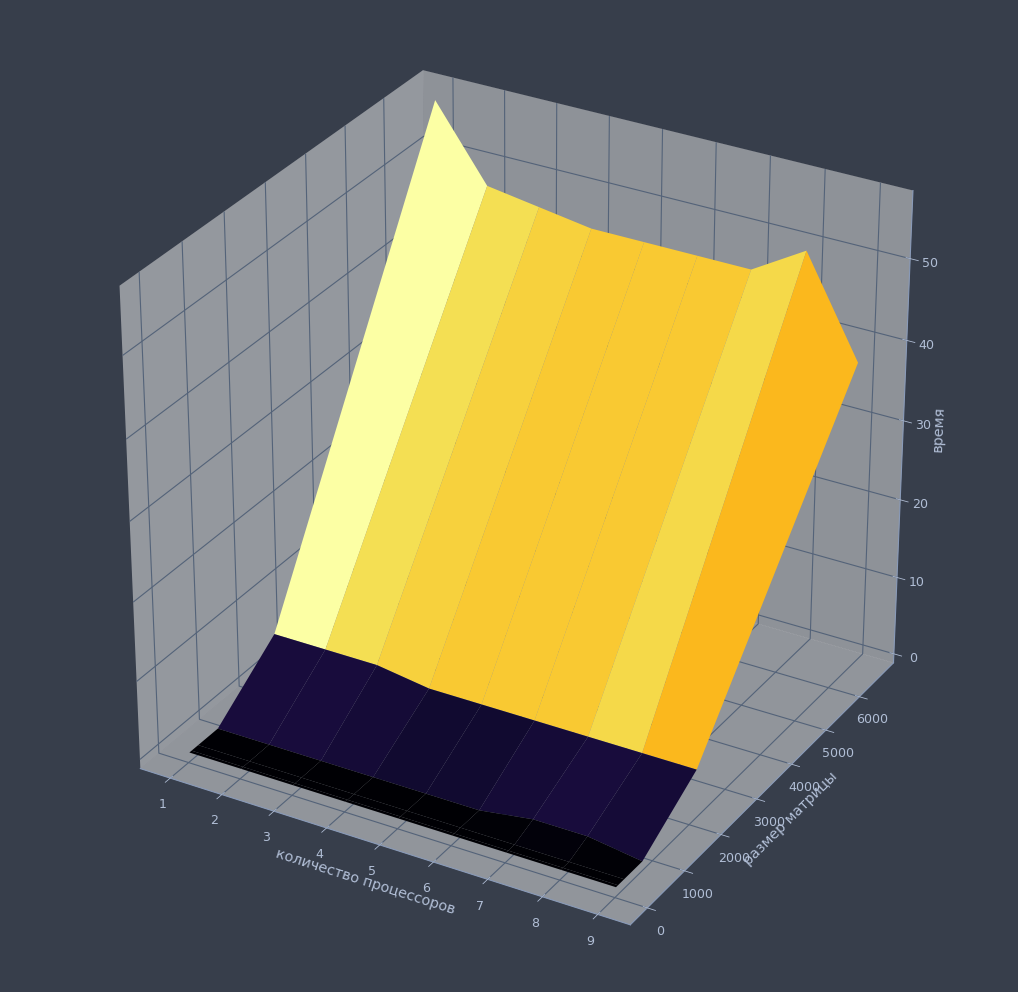

In [54]:
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(ygrid, xgrid, zgrid, cmap='inferno')
ax.set_ylabel('размер матрицы')
ax.set_xlabel('количество процессоров')
ax.set_zlabel('время')

### <center> Итог </center>

Выполнив курсовую работу по численным методам я узнал один из самых эффективных методов решения частичной задачи собственных значений симметричнй матрицы - методом Ланцоша, и даже реализовал его, вкупе с опитимизированным до линейного времени QR-алгоритмом, котрый позволяет находить все собственные значения трёхдиагональной матрицы.

Во время выполнения я столкнулся с массой трудностей, такими, как нехватка литературы на русском языке и незнание некоторых понятий линейной алгебры, однако я получил огромный багаж  знаний и опыта, решив эту задачу и преодолев все преграды на своём пути.

###### <center>Сделано Бронниковым Максимом</center>
###### <center>08.05.2020</center>